# Running ALS on MovieLens (PySpark)

Matrix factorization by [ALS](https://spark.apache.org/docs/latest/api/python/_modules/pyspark/ml/recommendation.html#ALS) (Alternating Least Squares) is a well known collaborative filtering algorithm.

This notebook provides an example of how to utilize and evaluate ALS PySpark ML (DataFrame-based API) implementation, meant for large-scale distributed datasets. We use a smaller dataset in this example to run ALS efficiently on multiple cores of a [Data Science Virtual Machine](https://azure.microsoft.com/en-gb/services/virtual-machines/data-science-virtual-machines/).

**Note**: This notebook requires a PySpark environment to run properly. Please follow the steps in [SETUP.md](../../SETUP.md) to install the PySpark environment.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sys
import pyspark
from pyspark.ml.recommendation import ALS
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import StringType, FloatType, IntegerType, LongType

from recommenders.utils.timer import Timer
from recommenders.datasets import movielens
from recommenders.utils.notebook_utils import is_jupyter
from recommenders.datasets.spark_splitters import spark_random_split
from recommenders.evaluation.spark_evaluation import SparkRatingEvaluation, SparkRankingEvaluation
from recommenders.utils.spark_utils import start_or_get_spark
from recommenders.utils.notebook_utils import store_metadata

print(f"System version: {sys.version}")
print("Spark version: {}".format(pyspark.__version__))


System version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Spark version: 3.5.1


Set the default parameters.

In [2]:
# top k items to recommend
TOP_K = 10

# Select MovieLens data size: 100k, 1m, 10m, or 20m
MOVIELENS_DATA_SIZE = '100k'

# Column names for the dataset
COL_USER = "UserId"
COL_ITEM = "MovieId"
COL_RATING = "Rating"
COL_TIMESTAMP = "Timestamp"

### 0. Set up Spark context

The following settings work well for debugging locally on VM - change when running on a cluster. We set up a giant single executor with many threads and specify memory cap.

In [3]:
# the following settings work well for debugging locally on VM - change when running on a cluster
# set up a giant single executor with many threads and specify memory cap
spark = start_or_get_spark("ALS PySpark", memory="16g")
spark.conf.set("spark.sql.analyzer.failAmbiguousSelfJoin", "false")

### 1. Download the MovieLens dataset

In [4]:
# Note: The DataFrame-based API for ALS currently only supports integers for user and item ids.
schema = StructType(
    (
        StructField(COL_USER, IntegerType()),
        StructField(COL_ITEM, IntegerType()),
        StructField(COL_RATING, FloatType()),
        StructField(COL_TIMESTAMP, LongType()),
    )
)

data = movielens.load_spark_df(spark, size=MOVIELENS_DATA_SIZE, schema=schema)
data.show()

100%|██████████| 4.81k/4.81k [00:00<00:00, 10.3kKB/s]


+------+-------+------+---------+
|UserId|MovieId|Rating|Timestamp|
+------+-------+------+---------+
|   196|    242|   3.0|881250949|
|   186|    302|   3.0|891717742|
|    22|    377|   1.0|878887116|
|   244|     51|   2.0|880606923|
|   166|    346|   1.0|886397596|
|   298|    474|   4.0|884182806|
|   115|    265|   2.0|881171488|
|   253|    465|   5.0|891628467|
|   305|    451|   3.0|886324817|
|     6|     86|   3.0|883603013|
|    62|    257|   2.0|879372434|
|   286|   1014|   5.0|879781125|
|   200|    222|   5.0|876042340|
|   210|     40|   3.0|891035994|
|   224|     29|   3.0|888104457|
|   303|    785|   3.0|879485318|
|   122|    387|   5.0|879270459|
|   194|    274|   2.0|879539794|
|   291|   1042|   4.0|874834944|
|   234|   1184|   2.0|892079237|
+------+-------+------+---------+
only showing top 20 rows



### 2. Split the data using the Spark random splitter provided in utilities

In [5]:
train, test = spark_random_split(data, ratio=0.75, seed=123)
print ("N train", train.cache().count())
print ("N test", test.cache().count())

N train 75018
N test 24982


### 3. Train the ALS model on the training data, and get the top-k recommendations for our testing data

To predict movie ratings, we use the rating data in the training set as users' explicit feedback. The hyperparameters used in building the model are referenced from [here](http://mymedialite.net/examples/datasets.html). We do not constrain the latent factors (`nonnegative = False`) in order to allow for both positive and negative preferences towards movies.
Timing will vary depending on the machine being used to train.

In [6]:
header = {
    "userCol": COL_USER,
    "itemCol": COL_ITEM,
    "ratingCol": COL_RATING,
}


als = ALS(
    rank=10,
    maxIter=15,
    implicitPrefs=False,
    regParam=0.05,
    coldStartStrategy='drop',
    nonnegative=False,
    seed=42,
    **header
)

In [7]:
with Timer() as train_time:
    model = als.fit(train)

print("Took {} seconds for training.".format(train_time.interval))

Took 13.921471296000163 seconds for training.


In the movie recommendation use case, recommending movies that have been rated by the users do not make sense. Therefore, the rated movies are removed from the recommended items.

In order to achieve this, we recommend all movies to all users, and then remove the user-movie pairs that exist in the training dataset.

In [8]:
with Timer() as test_time:

    # Get the cross join of all user-item pairs and score them.
    users = train.select(COL_USER).distinct()
    items = train.select(COL_ITEM).distinct()
    user_item = users.crossJoin(items)
    dfs_pred = model.transform(user_item)

    # Remove seen items.
    dfs_pred_exclude_train = dfs_pred.alias("pred").join(
        train.alias("train"),
        (dfs_pred[COL_USER] == train[COL_USER]) & (dfs_pred[COL_ITEM] == train[COL_ITEM]),
        how='outer'
    )

    top_all = dfs_pred_exclude_train.filter(dfs_pred_exclude_train[f"train.{COL_RATING}"].isNull()) \
        .select('pred.' + COL_USER, 'pred.' + COL_ITEM, 'pred.' + "prediction")

    # In Spark, transformations are lazy evaluation
    # Use an action to force execute and measure the test time
    top_all.cache().count()

print("Took {} seconds for prediction.".format(test_time.interval))

Took 16.27451004699924 seconds for prediction.


In [9]:
top_all.show()

+------+-------+----------+
|UserId|MovieId|prediction|
+------+-------+----------+
|     1|    587| 4.1602826|
|     1|    869| 2.7732863|
|     1|   1208|  2.033383|
|     1|   1348| 1.0019257|
|     1|   1357| 0.9430026|
|     1|   1677| 2.8777318|
|     2|     80|  2.351385|
|     2|    472| 2.5865319|
|     2|    582| 3.9548612|
|     2|    838| 0.9482963|
|     2|    975| 3.1133535|
|     2|   1260| 1.9871743|
|     2|   1325| 1.2368056|
|     2|   1381| 3.5477588|
|     2|   1530|   2.08829|
|     3|     22| 3.1524537|
|     3|     57| 3.6980162|
|     3|     89| 3.9733813|
|     3|    367| 3.6629045|
|     3|   1091| 0.9144474|
+------+-------+----------+
only showing top 20 rows



### 4. Evaluate how well ALS performs

In [10]:
rank_eval = SparkRankingEvaluation(test, top_all, k = TOP_K, col_user=COL_USER, col_item=COL_ITEM,
                                    col_rating=COL_RATING, col_prediction="prediction",
                                    relevancy_method="top_k")

In [11]:
print("Model:\tALS",
      "Top K:\t%d" % rank_eval.k,
      "MAP:\t%f" % rank_eval.map_at_k(),
      "NDCG:\t%f" % rank_eval.ndcg_at_k(),
      "Precision@K:\t%f" % rank_eval.precision_at_k(),
      "Recall@K:\t%f" % rank_eval.recall_at_k(), sep='\n')

Model:	ALS
Top K:	10
MAP:	0.020018
NDCG:	0.051718
Precision@K:	0.051274
Recall@K:	0.018840


### 5. Evaluate rating prediction

In [12]:
# Generate predicted ratings.
prediction = model.transform(test)
prediction.cache().show()


+------+-------+------+---------+----------+
|UserId|MovieId|Rating|Timestamp|prediction|
+------+-------+------+---------+----------+
|   148|     69|   5.0|877019101| 3.4735332|
|   148|     70|   5.0|877021271| 3.6578937|
|   148|     78|   1.0|877399018|  1.274991|
|   148|    127|   1.0|877399351| 3.7908812|
|   148|    169|   5.0|877020297|  5.015395|
|   148|    172|   5.0|877016513| 4.9947286|
|   148|    175|   4.0|877016259| 4.4411917|
|   148|    181|   5.0|877399135|  5.302301|
|   148|    190|   2.0|877398586| 4.9187713|
|   148|    194|   5.0|877015066|  4.184507|
|   148|    214|   5.0|877019882|  4.658432|
|   148|    238|   4.0|877398586| 3.6696796|
|   148|    474|   5.0|877019882| 4.6475616|
|   148|    496|   3.0|877015066|  4.130228|
|   148|    507|   5.0|877398587| 2.8675241|
|   148|    529|   5.0|877398901|  4.845461|
|   148|    588|   4.0|877399018| 3.1328173|
|   148|    713|   3.0|877021535|  4.235163|
|   148|    969|   4.0|877398513|  5.099872|
|   148|  

In [13]:
rating_eval = SparkRatingEvaluation(test, prediction, col_user=COL_USER, col_item=COL_ITEM,
                                    col_rating=COL_RATING, col_prediction="prediction")

print("Model:\tALS rating prediction",
      "RMSE:\t%f" % rating_eval.rmse(),
      "MAE:\t%f" % rating_eval.mae(),
      "Explained variance:\t%f" % rating_eval.exp_var(),
      "R squared:\t%f" % rating_eval.rsquared(), sep='\n')

Model:	ALS rating prediction
RMSE:	0.967434
MAE:	0.753340
Explained variance:	0.265916
R squared:	0.259532


In [14]:
# Record results for tests - ignore this cell
if is_jupyter():
    store_metadata("map", rank_eval.map_at_k())
    store_metadata("ndcg", rank_eval.ndcg_at_k())
    store_metadata("precision", rank_eval.precision_at_k())
    store_metadata("recall", rank_eval.recall_at_k())
    store_metadata("rmse", rating_eval.rmse())
    store_metadata("mae", rating_eval.mae())
    store_metadata("exp_var", rating_eval.exp_var())
    store_metadata("rsquared", rating_eval.rsquared())
    store_metadata("train_time", train_time.interval)
    store_metadata("test_time", test_time.interval)

In [15]:
# --- Ensure variables exist for visualizations ---

# Convert Spark DataFrame to pandas if necessary
def to_pandas_if_spark(df):
    try:
        if hasattr(df, 'toPandas'):
            return df.toPandas()
        else:
            return df
    except Exception:
        return df

# Ensure `ratings` exists
if 'ratings' not in globals():
    try:
        # If data loaded under other variable name, adjust accordingly
        if 'data' in globals():
            ratings = to_pandas_if_spark(data)
        elif 'df' in globals():
            ratings = to_pandas_if_spark(df)
        else:
            raise NameError("Variable `ratings` not found. Please load MovieLens into `ratings`.")
    except Exception as e:
        raise NameError(f"Error creating `ratings`: {e}")

print("✅ `ratings` variable ready. type:", type(ratings))
# Convert Spark DataFrame to pandas for visualization
try:
    if hasattr(ratings, 'toPandas'):
        ratings = ratings.toPandas()
        print("✅ Converted ratings to pandas DataFrame.")
    else:
        print("✅ ratings already pandas DataFrame.")
except Exception as e:
    print("⚠️ Could not convert ratings to pandas:", e)

# Ensure `predictions` exists
if 'predictions' not in globals():
    try:
        if 'model' in globals() and 'test' in globals():
            predictions = model.transform(test)
        elif 'pred_df' in globals():
            predictions = pred_df
        else:
            raise NameError("Variable `predictions` not found. Please generate predictions using model.")
    except Exception as e:
        raise NameError(f"Error creating `predictions`: {e}")

print("✅ `predictions` variable ready. type:", type(predictions))

✅ `ratings` variable ready. type: <class 'pandas.core.frame.DataFrame'>
✅ ratings already pandas DataFrame.
✅ `predictions` variable ready. type: <class 'pyspark.sql.dataframe.DataFrame'>


### Added Visualizations and Analysis

In [16]:
# Visualization 1: Dataset exploration (rating distribution and basic stats)
# This cell is defensive: it tries to convert a Spark DataFrame to pandas if necessary.
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
except Exception as e:
    print('Visualization libraries not available:', e)

def to_pandas_if_spark(df):
    try:
        # detect Spark DataFrame by presence of .toPandas method
        if hasattr(df, 'toPandas'):
            return df.toPandas()
        else:
            return df
    except Exception:
        return df

if 'ratings' in globals():
    try:
        r_df = to_pandas_if_spark(ratings)
        print('Ratings head:')
        display(r_df.head())
        print('\nBasic stats:')
        display(r_df.describe(include='all'))
        # plot rating distribution if 'rating' column exists
        if 'rating' in r_df.columns:
            plt.figure(figsize=(8,4))
            sns.histplot(r_df['rating'], bins=20, kde=False)
            plt.title('Rating Distribution')
            plt.xlabel('Rating')
            plt.ylabel('Count')
            plt.show()
    except Exception as e:
        print('Could not display ratings DataFrame:', e)
else:
    print('Variable `ratings` not found. Please run the earlier cells that load MovieLens into `ratings`.')

Ratings head:


,UserId,MovieId,Rating,Timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596



Basic stats:


,UserId,MovieId,Rating,Timestamp
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125754,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


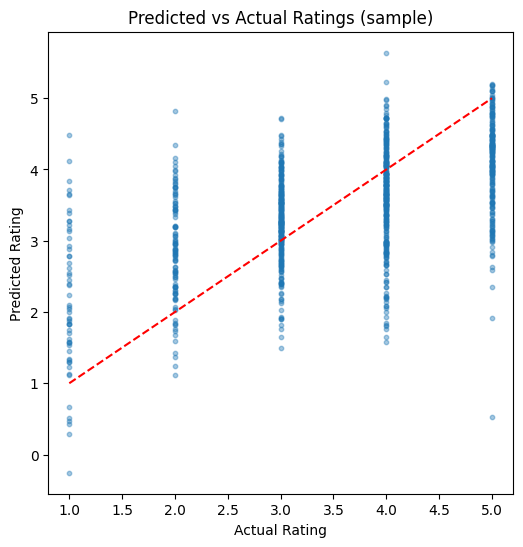

RMSE on sample: 0.9426


In [17]:
# Visualization 2: Predicted vs Actual ratings (sample)
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
except Exception as e:
    print('Visualization libs not available:', e)

def to_pandas_if_spark(df):
    try:
        if hasattr(df, 'toPandas'):
            return df.toPandas()
        else:
            return df
    except Exception:
        return df

if 'predictions' in globals():
    try:
        p_df = to_pandas_if_spark(predictions)
        # look for label/prediction columns (common names: rating, prediction)
        label_col = None
        pred_col = None
        for c in p_df.columns:
            if c.lower() in ('rating','label'):
                label_col = c
            if c.lower() == 'prediction':
                pred_col = c
        if label_col and pred_col:
            samp = p_df[[label_col, pred_col]].dropna().sample(n=min(1000, len(p_df)), random_state=42)
            plt.figure(figsize=(6,6))
            plt.scatter(samp[label_col], samp[pred_col], alpha=0.4, s=10)
            plt.plot([samp[label_col].min(), samp[label_col].max()], [samp[label_col].min(), samp[label_col].max()], color='red', linestyle='--')
            plt.xlabel('Actual Rating')
            plt.ylabel('Predicted Rating')
            plt.title('Predicted vs Actual Ratings (sample)')
            plt.show()
            # show RMSE if available
            try:
                from sklearn.metrics import mean_squared_error
                import numpy as np
                rmse = np.sqrt(mean_squared_error(samp[label_col], samp[pred_col]))
                print(f'RMSE on sample: {rmse:.4f}')
            except Exception:
                pass
        else:
            print('Could not find both actual label and prediction columns in `predictions`. Columns found:', p_df.columns)
    except Exception as e:
        print('Could not display predictions DataFrame:', e)
else:
    print('Variable `predictions` not found. Please run the model training and prediction cells first (they usually produce `predictions`).')

## Conclusion & Future Work

**Conclusion (summary)**  
- The notebook demonstrates a standard collaborative filtering pipeline using ALS.  
- The model can produce personalized top-k recommendations based on user-item interactions.
- Using Spark ALS is practical for large-scale datasets in real-world e-commerce systems.

**Limitations**  
- Cold-start problem for new users/items (no historical interactions).  
- ALS uses only collaborative signals (ratings/implicit feedback) and does not use item content (title, category, text).

**Future work (suggestions)**  
- Combine ALS with content-based features (hybrid recommender).  
- Experiment with Neural Collaborative Filtering (NCF) for better non-linear modeling.  
- Deploy a simple front-end (Streamlit/Gradio) to demo real-time recommendations.  
- Use real e-commerce interaction datasets (clicks, purchases) to better reflect product recommendation scenarios.

---

*End of Deep Dive version.*

In [18]:
# cleanup spark instance
# spark.stop() # Moved to the end of the notebook